In [2]:
from ING_PRO.mvtec2d import MVTec2D
from torchvision import transforms as T
from torch.utils.data import  ConcatDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from ING_PRO.AEUnet_SAM import ReconstructiveSubNetwork as ReconstructiveSubNetworkOri
from ING_PRO.loss import SSIM
from torch import Tensor
import torch
from torch import optim
from ING_PRO.loss import SSIM
import os
import numpy as np
from typing import Any, List, Optional, Tuple, Union
import torch.nn.functional as fn
import kornia
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torchvision.transforms.functional as TF
import random
from EfficientSAM.efficient_sam.build_efficient_sam import build_efficient_sam_vitt

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def weights_init(m):
    """
    init weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def get_freq_means_and_stds(x: Tensor) -> Tuple[Tensor]:
    freq = torch.fft.fft2(x)
    real_mean = freq.real.mean(dim=0)
    real_std = freq.real.std(dim=0)
    imag_mean = freq.imag.mean(dim=0)
    imag_std = freq.imag.std(dim=0)
    return real_mean, real_std, imag_mean, imag_std

def get_noise(
    real_mean: Tensor,
    real_std: Tensor,
    imag_mean: Tensor,
    imag_std: Tensor,
) -> Tensor:
    freq_real = torch.normal(real_mean, real_std)
    freq_imag = torch.normal(imag_mean, imag_std)
    freq = freq_real + 1j * freq_imag
    noise = torch.fft.ifft2(freq)
    return noise.real

def data_loader_my():
    img_transform = T.Compose([T.Resize((256, 256)),
                T.CenterCrop(256),
                T.ToTensor(),
                ])

    mask_transform = T.Compose([T.Resize(256),
                T.CenterCrop(256),
                T.ToTensor(),
                ])
    train_data_transform = img_transform, mask_transform

    dataset = MVTec2D(data_path='./MVTec',
                        learning_mode='centralized',
                        phase='test',
                        data_transform=train_data_transform,
                        num_task=1)
    dataloader = DataLoader(dataset, batch_size=2, num_workers=16,
                            sampler=SubsetRandomSampler(dataset.sample_indices_in_task[0]), drop_last=False)
    return dataloader

In [13]:
model_Rec = ReconstructiveSubNetworkOri(in_channels=3, out_channels=3)
model_Rec_copy = ReconstructiveSubNetworkOri(in_channels=3, out_channels=3).requires_grad_(False)
model_Rec.to(device)
model_Rec_copy.to(device)
model_Rec.apply(weights_init)
model_Rec.load_state_dict(torch.load(os.path.join('./IGN_SAM_1', f"epoch_5.pckl"), map_location='cuda:0'))
efficient_ti_model = build_efficient_sam_vitt().requires_grad_(False)

In [14]:
dataloader = data_loader_my()

In [19]:
def model_test(dataloader):
    kernel = torch.ones(3, 3).to(device)
    model_Rec.train()
    i = 12
    # for i_batch, sample_batched in enumerate(dataloader):
    sample_batched = dataloader.dataset[i]
    gray_batch = sample_batched["img"].clone()
    z  = efficient_ti_model.get_image_embeddings(
            gray_batch[None, ...]
        ).detach()
    z = z.to(device, memory_format=torch.contiguous_format)

    fz = model_Rec(z)
   
    f_z  = efficient_ti_model.get_image_embeddings(
            fz.detach().cpu()
        ).detach()
    f_z = f_z.to(device, memory_format=torch.contiguous_format)
    ff_z = model_Rec(f_z)
    return gray_batch, fz , ff_z

In [16]:
# 归一化函数
def normalize_with_clipping(image, lower_percentile=5, upper_percentile=95):
    # 计算上下分位数
    lower_bound = np.percentile(image, lower_percentile)
    upper_bound = np.percentile(image, upper_percentile)
    
    # 剪切
    image_clipped = np.clip(image, lower_bound, upper_bound)
    
    # 归一化
    image_normalized = (image_clipped - image_clipped.min()) / (image_clipped.max() - image_clipped.min())
    return image_normalized


In [20]:
image_temp , fz , ff_z = model_test(dataloader)

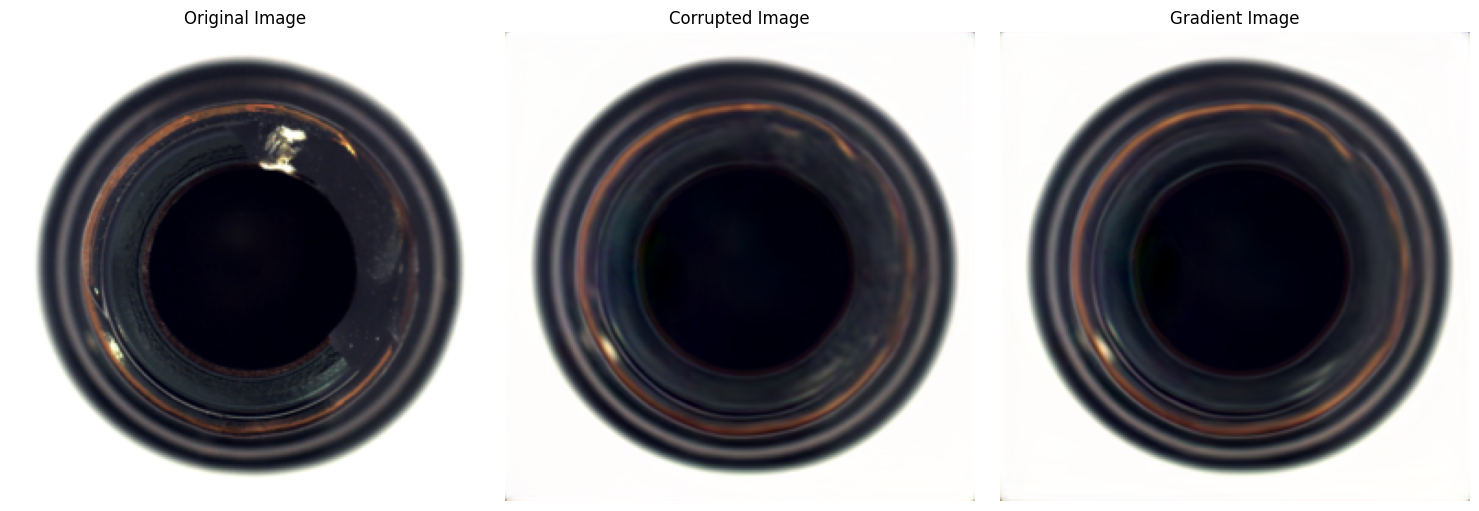

In [21]:
original_image = image_temp.squeeze(0).detach().cpu().permute(1, 2, 0).numpy()
corrupted_image_out = fz[0].squeeze(0).detach().cpu().permute(1, 2, 0).numpy()
gradient_image = ff_z[0].squeeze(0).detach().cpu().permute(1, 2, 0).numpy()

# 归一化图像
original_image = normalize_with_clipping(original_image)
corrupted_image_out = normalize_with_clipping(corrupted_image_out)
gradient_image = normalize_with_clipping(gradient_image)

# 创建图形
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image, vmin=0, vmax=1)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(corrupted_image_out, vmin=0, vmax=1)
plt.title("Corrupted Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(gradient_image, vmin=0, vmax=1)
plt.title("Gradient Image")
plt.axis('off')

# 显示图像
plt.tight_layout()
plt.show()